# 決算短信HTMLの読み取り可否状況レポート

決算短信のHTML化を実施している企業1330社のうち、ランダムに54社をサンプリングしHTMLファイルの読み取り可否状況を調査する。  

## 検証方法

各社のHTMLファイルを実際に読み込み、8つのステータスをチェックする。以下に、ステータスとプログラム上での表記を列記する。

1. 「報告セグメント」を含むテーブルが存在しない (`segment_table_not_exist`)
2. 「報告セグメント」を含むテーブルが1つしか存在しない (`too_little_segment_table`)
3. 「報告セグメント」を含むテーブルが前期と当期の3つ以上存在する (`too_much_segment_tables`)
4. テーブルの報告時期を示すテキストが存在しない (`period_not_found`)
5. 「報告セグメント」のテーブルからセグメントが取得できない (`segment_not_found`)
6. 「報告セグメント」のテーブルから売上・利益の勘定が取得できない (`account_not_found`)
7. 「報告セグメント」のテーブルから指定したセグメント、勘定のデータが読み取れない (`value_read_failed`)
8. 4~6のエラーなく読み取れた前期・当期のテーブルが存在する (`completed`)

`data/raw/HTML` 配下にあるファイルを一つ一つ読み込んでいき、ステータスをチェックする。

* 報告時期がなくセグメントも取得できない、などステータスは複数チェックされる可能性がある。
* 報告セグメントを含むテーブルが3つ以上ある場合でも(3)、4~7のエラーが発生せず読み取れた前期と当期のテーブルがある場合8がチェックされる。

## 検証

はじめに、HTMLファイルを読み込むためのライブラリとモジュール (`financial_result_to_dataframe`) を読み込む。

In [9]:
import sys
import dataclasses
from pathlib import Path
if "../" not in sys.path:
    sys.path.append("../")
import pandas as pd
from scripts.financial_result_to_dataframe import financial_result_to_dataframe

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


各HTMLファイルを読み込みステータスをチェックする。

In [11]:
data_dir = Path.cwd().joinpath("../data/raw/HTML")
company_dfs = {}
read_results = []

for dir in data_dir.iterdir():
    company_name = dir.name
    html_path = dir.joinpath("qualitative.htm")
    df, log = financial_result_to_dataframe(html_path)
    _result = dataclasses.asdict(log.status)
    for key in _result:
        _result[key] = 1 if _result[key] else 0 # Boolをintに変更
    _result["company_name"] = company_name
    company_dfs[company_name] = df
    read_results.append(_result)

read_result_df = pd.DataFrame(read_results).set_index("company_name")

In [12]:
len(read_result_df)

54

## 検証結果

54件のうち、28件(51%)は「「報告セグメント」を含むテーブルが存在しない」、20件(37%)は正常に読み取ることに成功している。

報告セグメントを含むテーブルがない場合、単一セグメントであることなどを理由にセグメント情報を開示していない可能性が高い。報告セグメントを含んでいる開示は全54件から28件を差し引いた26件であり、このうち20件が正常に読み取れていたことから7割超(76%)は今回のプログラムで正常に読み取れたことがわかる。

<AxesSubplot:>

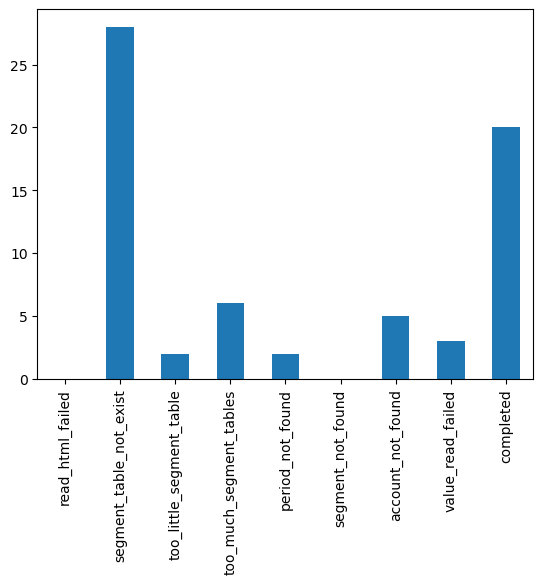

In [13]:
read_result_df.sum().plot.bar()

In [14]:
read_result_df.sum()

read_html_failed             0
segment_table_not_exist     28
too_little_segment_table     2
too_much_segment_tables      6
period_not_found             2
segment_not_found            0
account_not_found            5
value_read_failed            3
completed                   20
dtype: int64

前期、当期のテーブルがエラーなく読み取れた企業は以下のとおりである。読み取れたもののエラーがある企業は、いずれも複数のテーブルが記載されている(`too_much_segment_tables`)。

In [15]:
read_result_df[read_result_df.completed == 1].style.applymap(lambda x: "background-color: coral" if x > 0 else None)

,read_html_failed,segment_table_not_exist,too_little_segment_table,too_much_segment_tables,period_not_found,segment_not_found,account_not_found,value_read_failed,completed
company_name,,,,,,,,,
アスクル,0,0,0,1,0,0,1,0,1
オリンパス,0,0,0,0,0,0,0,0,1
セブン＆アイ・ホールディングス,0,0,0,0,0,0,0,0,1
トレイダーズホールディングス,0,0,0,0,0,0,0,0,1
ビックカメラ,0,0,0,0,0,0,0,0,1
マルハニチロ,0,0,0,0,0,0,0,0,1
ヨネックス,0,0,0,0,0,0,0,0,1
リンナイ,0,0,0,0,0,0,0,0,1
三和ホールディングス,0,0,0,0,0,0,0,0,1


アスクルの例: 「報告セグメント」を使用したテーブルが減損損失の報告にも使用されている。

![error_example_01.png](images/error_example_01.png)

報告セグメントのテーブルはあるが、エラーが発生した企業は以下のとおりである。

In [16]:
read_result_df[(read_result_df.completed == 0) & (read_result_df.segment_table_not_exist == 0)]\
    .style.applymap(lambda x: "background-color: coral" if x > 0 else None)

,read_html_failed,segment_table_not_exist,too_little_segment_table,too_much_segment_tables,period_not_found,segment_not_found,account_not_found,value_read_failed,completed
company_name,,,,,,,,,
アサヒグループホールディングス,0,0,1,0,0,0,1,0,0
ソフトバンク,0,0,0,1,1,0,0,0,0
ブリヂストン,0,0,0,0,0,0,0,1,0
味の素,0,0,0,0,0,0,0,1,0
大和証券グループ本社,0,0,1,0,0,0,0,0,0
高知銀行,0,0,0,1,0,0,1,0,0


アサヒグループホールディングスは、利益の勘定が存在しない。

![error_example_02.png](images/error_example_02.png)

この報告は「報告セグメントの変更」で使用されており、セグメント報告本体は「報告セグメント」を含まないテーブルで報告されている。

![error_example_03.png](images/error_example_03.png)

ソフトバンクは独特な期間の書き方をしている(54社の中でソフトバンクのみ期間が取得できない書き方をしている)。

![error_example_04.png](images/error_example_04.png)

ブリジストンは隠れ空白行があり、売上の下の行が利益となっていない。

![error_example_05.png](images/error_example_05.png)

味の素は持ち分法による損益の調整行があり、売上の下の行が利益となっていない。

![error_example_06.png](images/error_example_06.png)

大和証券グループ本社、高知銀行は当連結会計年度の報告しかない。

サンプリングした中では、利益の書き方、前期の報告有無がデータの取得可否を分けている。「報告セグメント」を含むテーブルによる報告はおおむね統一されていると見える。一方で、「報告セグメント」を含まないテーブルでセグメント報告をしている企業には注意が必要である。

セグメント報告の様式を整え、勘定のテキストや行の記載を形式化すればさらにデータが取得できるようになることが期待される。